INFO:data_loader:Successfully connected to MongoDB
INFO:data_loader:Loaded 516 stations
INFO:data_loader:Querying data between 2024-08-31T23:55:00 and 2024-10-01T00:15:00
INFO:data_loader:Loaded 4426712 status records
C:\Users\danys\AppData\Local\Temp\ipykernel_33796\3415981143.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = station_data['num_bikes_available'].resample('H').mean()


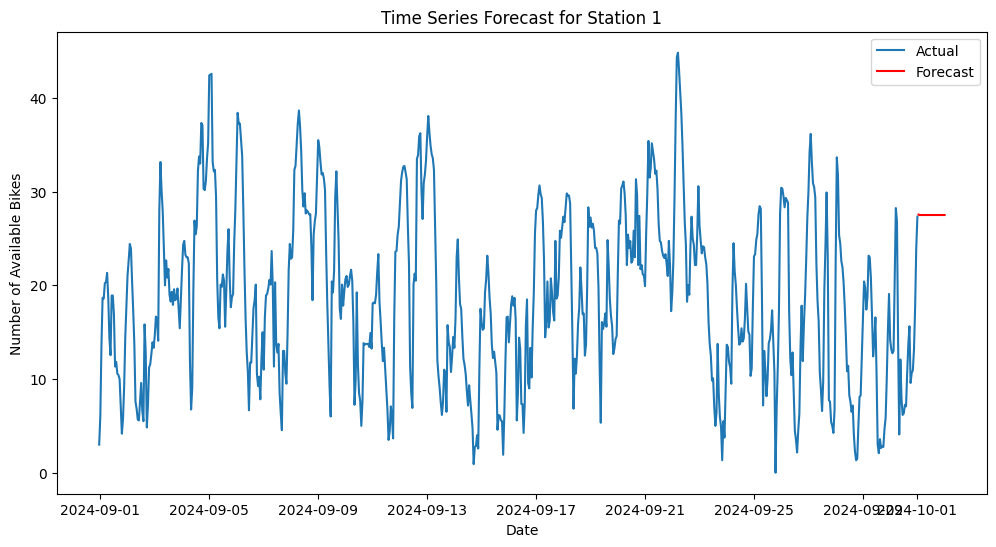

In [2]:
from datetime import datetime
from data_loader import connect_to_mongodb, load_stations_info, load_status_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import logging

# Connect to MongoDB and load data
db = connect_to_mongodb()
stations_info = load_stations_info(db)

# Adjust the date range to match available data
start_date = datetime(2024, 8, 31, 23, 55)
end_date = datetime(2024, 10, 1, 0, 15)
status_data = load_status_data(db, start_date, end_date)

# Check if data is loaded
if status_data.empty:
    logger.error("No data loaded. Please check the date range and data availability.")
else:
    # Preprocess data
    status_data['last_reported'] = pd.to_datetime(status_data['last_reported'])
    merged_data = pd.merge(status_data, stations_info, on='station_id', how='inner')
    merged_data['hour'] = merged_data['last_reported'].dt.hour
    merged_data['day_of_week'] = merged_data['last_reported'].dt.dayofweek

    # Time Series Analysis
    def perform_time_series_analysis(data, station_id):
        station_data = data[data['station_id'] == station_id].set_index('last_reported')
        hourly_data = station_data['num_bikes_available'].resample('H').mean()
        model = ARIMA(hourly_data, order=(1, 1, 1))
        results = model.fit()
        forecast = results.forecast(steps=24)
        return hourly_data, forecast, results

    # Example for a single station
    station_id = merged_data['station_id'].iloc[0]
    hourly_data, forecast, results = perform_time_series_analysis(merged_data, station_id)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_data.index, hourly_data, label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title(f'Time Series Forecast for Station {station_id}')
    plt.xlabel('Date')
    plt.ylabel('Number of Available Bikes')
    plt.legend()
    plt.show()

INFO:data_loader:Successfully connected to MongoDB
INFO:data_loader:Loaded 516 stations
INFO:data_loader:Querying data between 2024-08-31T23:55:00 and 2024-10-01T00:15:00
INFO:data_loader:Loaded 4426712 status records


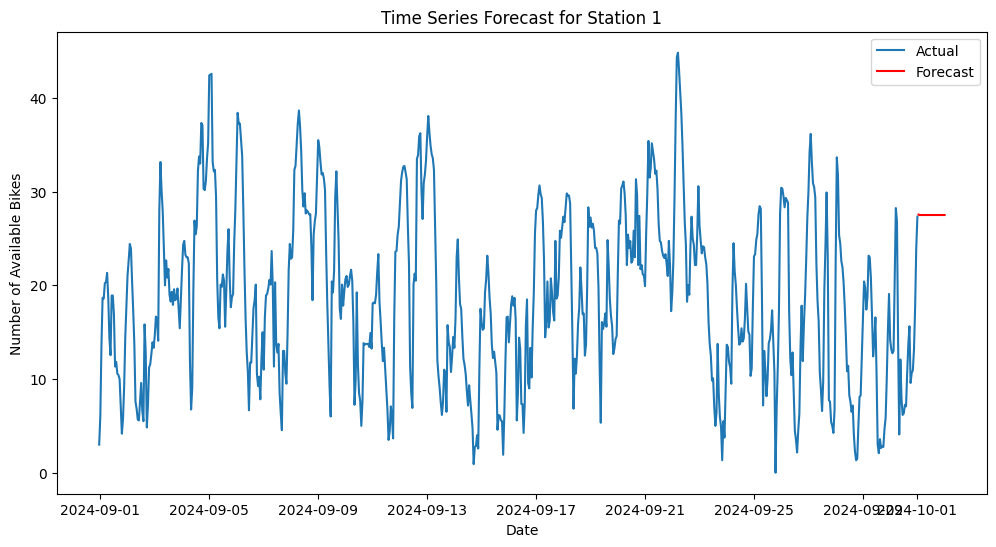

ValueError: operands could not be broadcast together with shapes (722,) (24,) 

In [4]:
from datetime import datetime
from data_loader import connect_to_mongodb, load_stations_info, load_status_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Connect to MongoDB and load data
db = connect_to_mongodb()
stations_info = load_stations_info(db)

# Adjust the date range to match available data
start_date = datetime(2024, 8, 31, 23, 55)
end_date = datetime(2024, 10, 1, 0, 15)
status_data = load_status_data(db, start_date, end_date)

# Check if data is loaded
if status_data.empty:
    logger.error("No data loaded. Please check the date range and data availability.")
else:
    # Preprocess data
    status_data['last_reported'] = pd.to_datetime(status_data['last_reported'])
    merged_data = pd.merge(status_data, stations_info, on='station_id', how='inner')
    merged_data['hour'] = merged_data['last_reported'].dt.hour
    merged_data['day_of_week'] = merged_data['last_reported'].dt.dayofweek

    # Time Series Analysis
    def perform_time_series_analysis(data, station_id):
        station_data = data[data['station_id'] == station_id].set_index('last_reported')
        hourly_data = station_data['num_bikes_available'].resample('h').mean()  # Use 'h' instead of 'H'
        model = ARIMA(hourly_data, order=(1, 1, 1))
        results = model.fit()
        forecast = results.forecast(steps=24)
        return hourly_data, forecast, results

    # Example for a single station
    station_id = merged_data['station_id'].iloc[0]
    hourly_data, forecast, results = perform_time_series_analysis(merged_data, station_id)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_data.index, hourly_data, label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title(f'Time Series Forecast for Station {station_id}')
    plt.xlabel('Date')
    plt.ylabel('Number of Available Bikes')
    plt.legend()
    plt.show()

    # Calculate metrics
    def calculate_metrics(y_true, y_pred):
        mae = np.mean(np.abs(y_true - y_pred))
        mse = np.mean((y_true - y_pred) ** 2)
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        return mae, mse, r2

    # Align y_actual and y_pred for the same time period
    # Assuming forecast is for the last 24 hours of the actual data
    y_actual = hourly_data[-24:].values
    y_pred = forecast.values

    mae, mse, r2 = calculate_metrics(y_actual, y_pred)
    print(f"MAE: {mae}, MSE: {mse}, R2: {r2}")

    # Plot actual vs. predicted
    def plot_actual_vs_predicted(hourly_data, forecast):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=hourly_data.index[-24:], y=hourly_data[-24:], mode='lines', name='Actual'))
        fig.add_trace(go.Scatter(x=forecast.index, y=forecast, mode='lines', name='Forecast'))
        fig.update_layout(title='Actual vs. Forecasted Bike Availability', xaxis_title='Time', yaxis_title='Bikes Available')
        fig.show()

    plot_actual_vs_predicted(hourly_data, forecast)